In [11]:
from GraphSummarizers.Coarsener.HeteroCoarsener import HeteroCoarsener
from Datasets.NodeClassification.DBLP import DBLP
from Datasets.NodeClassification.TestHetero import TestHeteroSmall, TestHeteroBig
import importlib
import torch

In [3]:

dataset = DBLP() 
original_graph = dataset.load_graph()


test = TestHeteroSmall().load_graph()

test = TestHeteroBig().load_graph()

coarsener = HeteroCoarsener(dataset, original_graph, 0.5)



In [4]:
H = coarsener._create_h_spatial_rgcn(original_graph)
candidates = coarsener._select_candidates(coarsener._find_lowest_cost_edges(coarsener._get_rgcn_edges(H)))
merged_graph = coarsener._merge_nodes(original_graph, "author", candidates["author"])
print(merged_graph)
print(original_graph)
#coarsener._costs_of_merges(candidates)

#coarsener._merge()

/home/robin/thesis/convolution-matching/GraphSummarizers/Coarsener/HeteroCoarsener.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  degree = torch.tensor(self.node_degrees[etype]["out"])
/home/robin/thesis/convolution-matching/GraphSummarizers/Coarsener/HeteroCoarsener.py:102: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  degree = torch.tensor(self.node_degrees[etype]["in"])


start init costs
(Graph(num_nodes={'author': 2585, 'conference': 20, 'paper': 14328, 'term': 7723},
      num_edges={('author', 'authortopaper', 'paper'): 19582, ('conference', 'conferencetopaper', 'paper'): 14328, ('paper', 'papertoauthor', 'author'): 4901, ('paper', 'papertoconference', 'conference'): 14328, ('paper', 'papertoterm', 'term'): 85810, ('term', 'termtopaper', 'paper'): 85810},
      metagraph=[('author', 'paper', 'authortopaper'), ('paper', 'author', 'papertoauthor'), ('paper', 'conference', 'papertoconference'), ('paper', 'term', 'papertoterm'), ('conference', 'paper', 'conferencetopaper'), ('term', 'paper', 'termtopaper')]), tensor([1113, 1114, 1115,  ..., 1572, 1550, 1112]))
Graph(num_nodes={'author': 4057, 'conference': 20, 'paper': 14328, 'term': 7723},
      num_edges={('author', 'authortopaper', 'paper'): 19645, ('conference', 'conferencetopaper', 'paper'): 14328, ('paper', 'papertoauthor', 'author'): 19645, ('paper', 'papertoconference', 'conference'): 14328, ('p

In [6]:
merged_graph, mapping = merged_graph

In [20]:
from torch_geometric.data import HeteroData

from torch_geometric.utils import from_dgl

def dgl_to_pyg_input(g):
    # Convert DGL heterograph to PyG's HeteroData
    pyg_data = from_dgl(g)

    x_dict = {}
    for ntype in g.ntypes:
        x_dict[ntype] = g.nodes[ntype].data['feat']

    edge_index_dict = {}
    for canonical_etype in g.canonical_etypes:
        src_type, rel_type, dst_type = canonical_etype
        src, dst = g.edges(etype=canonical_etype)
        edge_index = torch.stack([src, dst], dim=0)
        edge_index_dict[(src_type, rel_type, dst_type)] = edge_index

    return pyg_data,x_dict, edge_index_dict, g.ntypes, g.canonical_etypes


In [24]:
original_data, o_x_dict, o_edge_index_dict, o_node_types, o_edge_types = dgl_to_pyg_input(original_graph)
coarsened_data, c_x_dict, c_edge_index_dict, c_node_types, c_edge_types = dgl_to_pyg_input(merged_graph)

In [29]:
original_data

HeteroData(
  author={
    feat=[4057, 334],
    label=[4057],
  },
  conference={ feat=[20, 1] },
  paper={ feat=[14328, 4231] },
  term={ feat=[7723, 50] },
  (author, authortopaper, paper)={ edge_index=[2, 19645] },
  (conference, conferencetopaper, paper)={ edge_index=[2, 14328] },
  (paper, papertoauthor, author)={ edge_index=[2, 19645] },
  (paper, papertoconference, conference)={ edge_index=[2, 14328] },
  (paper, papertoterm, term)={ edge_index=[2, 85810] },
  (term, termtopaper, paper)={ edge_index=[2, 85810] }
)

In [31]:
import torch
import numpy as np
from torch_geometric.data import HeteroData

# Assuming you already have your hetero_data object
# hetero_data = HeteroData(...)

def create_train_val_test_masks(hetero_data, train_ratio=0.1, val_ratio=0.1, test_ratio=0.8, random_state=42):
    """
    Create training, validation, and testing masks for author nodes.
    
    Args:
        hetero_data: HeteroData object
        train_ratio: Ratio of training data
        val_ratio: Ratio of validation data
        test_ratio: Ratio of testing data
        random_state: Random seed for reproducibility
    
    Returns:
        HeteroData object with train_mask, val_mask, and test_mask added to author nodes
    """
    # Ensure ratios sum to 1
    assert abs(train_ratio + val_ratio + test_ratio - 1.0) < 1e-6, "Ratios must sum to 1"
    
    # Get number of author nodes
    num_authors = hetero_data['author']["feat"].size(0)
    
    # Create random permutation of node indices
    np.random.seed(random_state)
    indices = np.random.permutation(num_authors)
    
    # Calculate split sizes
    train_size = int(num_authors * train_ratio)
    val_size = int(num_authors * val_ratio)
    
    # Split indices
    train_indices = indices[:train_size]
    val_indices = indices[train_size:train_size + val_size]
    test_indices = indices[train_size + val_size:]
    
    # Create boolean masks
    train_mask = torch.zeros(num_authors, dtype=torch.bool)
    val_mask = torch.zeros(num_authors, dtype=torch.bool)
    test_mask = torch.zeros(num_authors, dtype=torch.bool)
    
    train_mask[train_indices] = True
    val_mask[val_indices] = True
    test_mask[test_indices] = True
    
    # Add masks to hetero_data
    hetero_data['author'].train_mask = train_mask
    hetero_data['author'].val_mask = val_mask
    hetero_data['author'].test_mask = test_mask
    
    # Print split statistics
    print(f"Split statistics:")
    print(f"  Training: {train_mask.sum()} nodes ({train_mask.sum() / num_authors:.2%})")
    print(f"  Validation: {val_mask.sum()} nodes ({val_mask.sum() / num_authors:.2%})")
    print(f"  Testing: {test_mask.sum()} nodes ({test_mask.sum() / num_authors:.2%})")
    
    return hetero_data

# Example usage
original_data =  create_train_val_test_masks(original_data, train_ratio=0.1, val_ratio=0.1, test_ratio=0.8)
coarsened_data = create_train_val_test_masks(coarsened_data, train_ratio=0.1, val_ratio=0.1, test_ratio=0.8)

# Accessing the masks
# train_nodes = hetero_data['author'].x[hetero_data['author'].train_mask]
# val_nodes = hetero_data['author'].x[hetero_data['author'].val_mask]
# test_nodes = hetero_data['author'].x[hetero_data['author'].test_mask]


Split statistics:
  Training: 405 nodes (9.98%)
  Validation: 405 nodes (9.98%)
  Testing: 3247 nodes (80.03%)
Split statistics:
  Training: 258 nodes (9.98%)
  Validation: 258 nodes (9.98%)
  Testing: 2069 nodes (80.04%)


tensor([ True,  True,  True,  ...,  True,  True, False])
Epoch 1:
  Original Graph - Loss: 1.4359, Accuracy: 0.4038
  Coarsened Graph - Loss: 1.4138, Accuracy: 0.5597
  Inverted Coarsened - Accuracy: 0.5554

tensor([ True,  True,  True,  ...,  True,  True, False])
Epoch 11:
  Original Graph - Loss: 0.0265, Accuracy: 0.7829
  Coarsened Graph - Loss: 0.0327, Accuracy: 0.7216
  Inverted Coarsened - Accuracy: 0.7202

tensor([ True,  True,  True,  ...,  True,  True, False])
Epoch 21:
  Original Graph - Loss: 0.0011, Accuracy: 0.7616
  Coarsened Graph - Loss: 0.0056, Accuracy: 0.6960
  Inverted Coarsened - Accuracy: 0.6931

tensor([ True,  True,  True,  ...,  True,  True, False])
Epoch 31:
  Original Graph - Loss: 0.0089, Accuracy: 0.7555
  Coarsened Graph - Loss: 0.0018, Accuracy: 0.6960
  Inverted Coarsened - Accuracy: 0.6983

tensor([ True,  True,  True,  ...,  True,  True, False])
Epoch 41:
  Original Graph - Loss: 0.0033, Accuracy: 0.7570
  Coarsened Graph - Loss: 0.0013, Accuracy: 0.67

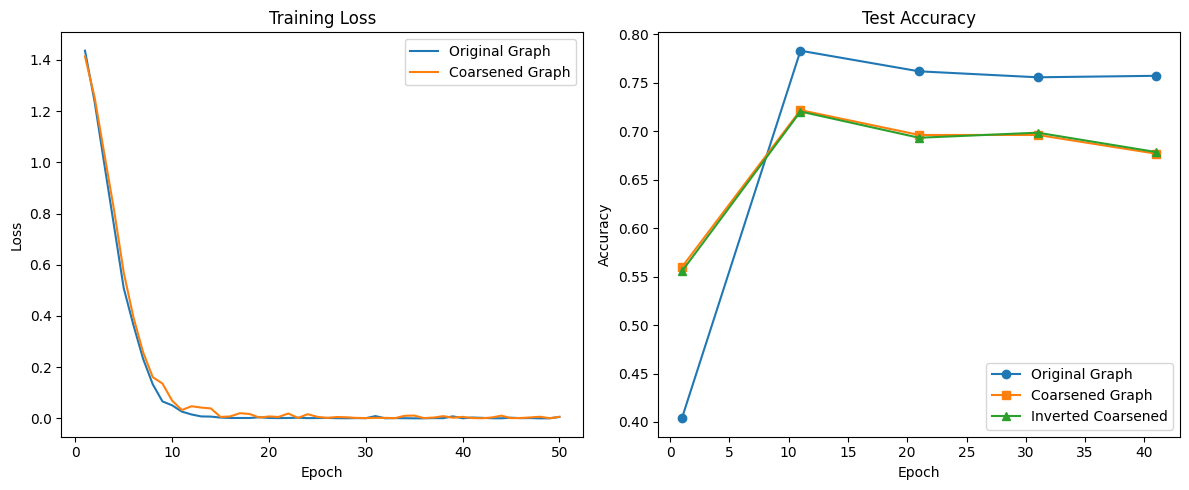

Final Performance Comparison:
Original Graph Accuracy: 0.7570
Coarsened Graph Accuracy: 0.6767
Inverted Coarsened Accuracy: 0.6784


In [ ]:
# Import necessary libraries (if not already imported)
import torch
import torch.nn.functional as F
import numpy as np
from Models.GNNs.HGCN import ImprovedHeteroGNN


original_x_dict = o_x_dict
coarsened_x_dict = c_x_dict
o_metadata = (o_node_types, o_edge_types)
c_metadata=(c_node_types, c_edge_types)
#original_x_dict.update({"conference": torch.zeros((original_data["conference"]["num_nodes"], 1))})# = 0  #= 0#
#coarsened_x_dict.update({"conference": torch.zeros((coarsened_data["conference"]["num_nodes"], 1))})# = 0  #= 0#

#num_classes = len(original_data["author"]["label"].unique())

# Your existing model definition
model_original = ImprovedHeteroGNN(metadata=o_metadata, x_dict= original_x_dict ,num_classes= 4,hidden_channels=64)
model_coarsened = ImprovedHeteroGNN(metadata=c_metadata, x_dict= coarsened_x_dict,num_classes= 4, hidden_channels=64)

# Optimizers
optimizer_original = torch.optim.Adam(model_original.parameters(), lr=0.01, weight_decay=5e-4)
optimizer_coarsened = torch.optim.Adam(model_coarsened.parameters(), lr=0.01, weight_decay=5e-4)

def remap_edge_indices(edge_index_dict, node_mapping):
    """
    Remaps edge indices according to the new node IDs in the coarsened graph
    
    Args:
        edge_index_dict: Dictionary of edge indices for each relation type
        node_mapping: Dictionary mapping original node IDs to coarsened node IDs
        
    Returns:
        Remapped edge index dictionary
    """
    remapped_edge_index_dict = {}
    for edge_type, edge_index in edge_index_dict.items():
        src_type, rel_type, dst_type = edge_type
        
        # Remap source and destination node IDs
        src_mapping = node_mapping.get(src_type, {})
        dst_mapping = node_mapping.get(dst_type, {})
        
        # Create new edge index tensor
        new_edge_index = torch.zeros_like(edge_index)
        for i in range(edge_index.size(1)):
            src_id = edge_index[0, i].item()
            dst_id = edge_index[1, i].item()
            
            # Use mapped IDs
            new_edge_index[0, i] = src_mapping.get(src_id, src_id)
            new_edge_index[1, i] = dst_mapping.get(dst_id, dst_id)
        
        remapped_edge_index_dict[edge_type] = new_edge_index
    
    return remapped_edge_index_dict


# Function to apply inversion mapping from coarsened to original
def apply_inversion_mapping(coarsened_pred, inversion_map, original_labels, test_mask):
    """
    Maps predictions from coarsened graph back to original graph nodes
    
    Args:
        coarsened_pred: Predictions on coarsened graph
        inversion_map: Mapping from coarsened nodes to original nodes
        original_labels: Ground truth labels of original graph
        
    Returns:
        mapped_accuracy: Accuracy after applying inversion mapping
    """
    correct_count = 0
    total_count = 0
    
    for orig_node, coarsened_node in enumerate(inversion_map):
        if not test_mask[coarsened_node]:
            continue
        coarse_pred = coarsened_pred[coarsened_node].item()
        orig_label = original_labels[orig_node].item()
        #print(coarse_pred, orig_label)

        correct = (coarse_pred == orig_label)
                
        if correct:
            correct_count += 1
        total_count += 1
    
    return correct_count / total_count if total_count > 0 else 0

# Training function for original graph
def train_original():
    model_original.train()
    optimizer_original.zero_grad()
    
    out = model_original(original_x_dict, original_data.edge_index_dict)
    loss = F.nll_loss(
        out['author'][original_data['author'].train_mask], 
        original_data['author']["label"][original_data['author'].train_mask]
    )
    loss.backward()
    optimizer_original.step()
    return loss.item()

# Training function for coarsened graph
def train_coarsened():
    model_coarsened.train()
    optimizer_coarsened.zero_grad()
    out = model_coarsened(coarsened_x_dict, coarsened_data.edge_index_dict)
    loss = F.nll_loss(
        out['author'][coarsened_data['author'].train_mask], 
        coarsened_data['author']["label"][coarsened_data['author'].train_mask]
    )
    loss.backward()
    optimizer_coarsened.step()
    return loss.item()

# Evaluation function for original graph
def test_original():
    model_original.eval()
    with torch.no_grad():
        out = model_original(original_x_dict, original_data.edge_index_dict)
        pred = out["author"].argmax(dim=1)
        
        # Calculate accuracy on test set
        correct = pred[original_data['author'].test_mask] == original_data['author']["label"][original_data['author'].test_mask]
        acc = int(correct.sum()) / int(original_data['author'].test_mask.sum())
        return acc

# Evaluation function for coarsened graph
def test_coarsened():
    model_coarsened.eval()
    with torch.no_grad():
        out = model_coarsened(coarsened_x_dict, coarsened_data.edge_index_dict)
        pred = out["author"].argmax(dim=1)
        
        # Calculate accuracy on test set
        coarsened_acc = int(
            (pred[coarsened_data['author'].test_mask] == 
             coarsened_data['author']["label"][coarsened_data['author'].test_mask]).sum()
        ) / int(coarsened_data['author'].test_mask.sum())
        
        # Apply inversion mapping to evaluate how coarsened predictions map to original graph
        inverted_acc  = apply_inversion_mapping(
            pred,
            mapping,
            original_data['author']["label"], 
            coarsened_data['author'].test_mask
        )
       
        return coarsened_acc, inverted_acc

# Training for 50 epochs and comparing both models
results = {
    "epoch": [],
    "original_loss": [],
    "coarsened_loss": [],
    "original_acc": [],
    "coarsened_acc": [],
    "inverted_acc": []
}

for epoch in range(50):
    # Train both models
    original_loss = train_original()
    coarsened_loss = train_coarsened()
    
    # Store results
    results["epoch"].append(epoch+1)
    results["original_loss"].append(original_loss)
    results["coarsened_loss"].append(coarsened_loss)
    
    # Evaluate every 10 epochs
    if epoch % 10 == 0:
        original_acc = test_original()
        coarsened_acc, inverted_acc = test_coarsened()
        
        results["original_acc"].append(original_acc)
        results["coarsened_acc"].append(coarsened_acc)
        results["inverted_acc"].append(inverted_acc)
        
        print(f'Epoch {epoch+1}:')
    
    
        print(f'  Original Graph - Loss: {original_loss:.4f}, Accuracy: {original_acc:.4f}')
        print(f'  Coarsened Graph - Loss: {coarsened_loss:.4f}, Accuracy: {coarsened_acc:.4f}')
        print(f'  Inverted Coarsened - Accuracy: {inverted_acc:.4f}')
        print()

# Visualization of results
import matplotlib.pyplot as plt

# Plot loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(results["epoch"], results["original_loss"], label="Original Graph")
plt.plot(results["epoch"], results["coarsened_loss"], label="Coarsened Graph")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
x = [results["epoch"][i] for i in range(0, 50, 10)]
plt.plot(x, results["original_acc"], 'o-', label="Original Graph")
plt.plot(x, results["coarsened_acc"], 's-', label="Coarsened Graph")
plt.plot(x, results["inverted_acc"], '^-', label="Inverted Coarsened")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Test Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

# Final comparison
print("Final Performance Comparison:")
print(f"Original Graph Accuracy: {results['original_acc'][-1]:.4f}")
print(f"Coarsened Graph Accuracy: {results['coarsened_acc'][-1]:.4f}")
print(f"Inverted Coarsened Accuracy: {results['inverted_acc'][-1]:.4f}")

# Calculate speedup from using coarsened graph
# (You would need to time the training for a proper comparison)